In [1]:
from neuroaiengines.utils.plotting import *
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import matplotlib
import itertools
matplotlib.rcParams['figure.figsize'] = [6,4]
matplotlib.rcParams['figure.dpi'] = 200
from neuroaiengines.networks import create_symmetric_hemi_ra_matrix
N_EPG=8
_, slcs = create_symmetric_hemi_ra_matrix(N_EPG,gaussian=True, both=True, null_offset=True)

In [15]:
example_dir = os.path.join('..','examples')
color1 = 'tab:red'
color2 = 'tab:green'
color3 = 'tab:blue'
color4 = 'tab:orange'
cmap1 = 'plasma'


In [16]:
def load_data(network_type, pprint_name):
    # Load the data from the outputs of the testing/training
    dir = os.path.join(example_dir, network_type,'data')
    testing_dataframe = pd.read_pickle(os.path.join(dir,'testing_outputs.pkl'))
    training_dataframe = pd.read_pickle(os.path.join(dir,'train_metadata.pkl'))
    l,l1= [],[]
    
    # Iterate over the different tests
    for i, row in testing_dataframe.iterrows():
    
        T = row.states.shape[0]-1
        N = row.states.shape[1]
        Nn = np.arange(N)
        # Group state by population
        for pop, slc in slcs.items():
            pN = Nn[slc]
            for j,n in enumerate(pN):
                for t in range(T):
                    l.append({
                        't':t,
                        'population':pop,
                        'network_type':pprint_name,
                        'wedge':j,
                        'hemisphere': 'L' if j < N_EPG//2 else 'R',
                        'value':row.states[t,n],
                        'test_no':i//2
                    })
    # Grab ground truth angles
    for t in range(T):
        l1.append({
            't':t,
            'angle':row.decoded_angle[t],
            'ground_truth':row.ground_truth[t][0],
            'network_type':pprint_name,
            'test_no':i//2,
        })
    loss_df = pd.melt(training_dataframe, value_vars=['mean_loss','final_loss'],var_name='loss_type')
    loss_df['network_type'] = pprint_name
    states_df = pd.DataFrame(l)
    angle_df = pd.DataFrame(l1)
    
    return loss_df,states_df,angle_df,testing_dataframe['states']
null_offset_data = load_data('null_offset','Null offset')
synapse_level_data = load_data('synapse_level','Synapse-level')
states_matrices = {}
loss_df = pd.concat((null_offset_data[0],synapse_level_data[0]))
states_df = pd.concat((null_offset_data[1],synapse_level_data[1]))
angle_df = pd.concat((null_offset_data[2],synapse_level_data[2]))
states_matrices['Synapse-level'] = synapse_level_data[3]
states_matrices['Null offset'] = null_offset_data[3]

In [17]:
loss_df

,loss_type,value,network_type
0,mean_loss,3.163559,Null offset
1,mean_loss,3.163426,Null offset
2,mean_loss,3.163301,Null offset
3,mean_loss,3.163160,Null offset
4,mean_loss,3.163027,Null offset
...,...,...,...
11995,final_loss,3.348233,Synapse-level
11996,final_loss,3.348233,Synapse-level
11997,final_loss,3.348233,Synapse-level
11998,final_loss,3.348233,Synapse-level


In [18]:
angle_df

,t,angle,ground_truth,network_type,test_no
0,0,0.193773,0.000000,Null offset,0
1,1,0.193730,0.012566,Null offset,0
2,2,0.193846,0.025133,Null offset,0
3,3,0.194155,0.037699,Null offset,0
4,4,0.195476,0.050265,Null offset,0
...,...,...,...,...,...
495,495,-2.749177,6.220353,Synapse-level,0
496,496,-2.749165,6.232920,Synapse-level,0
497,497,-2.749153,6.245486,Synapse-level,0
498,498,-2.749142,6.258053,Synapse-level,0


In [19]:
states_df

,t,population,network_type,wedge,hemisphere,value,test_no
0,0,epg,Null offset,0,L,0.482305,0
1,1,epg,Null offset,0,L,0.504352,0
2,2,epg,Null offset,0,L,0.523908,0
3,3,epg,Null offset,0,L,0.541157,0
4,4,epg,Null offset,0,L,0.556864,0
...,...,...,...,...,...,...,...
35995,495,d7,Synapse-level,7,R,0.327690,0
35996,496,d7,Synapse-level,7,R,0.327688,0
35997,497,d7,Synapse-level,7,R,0.327687,0
35998,498,d7,Synapse-level,7,R,0.327685,0


# Fig. 4: The loss over the training period.

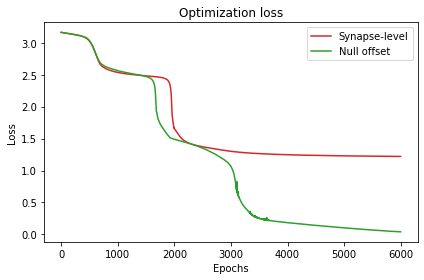

In [21]:
fig, ax = plt.subplots()
syn_loss = loss_df.query("loss_type=='mean_loss' & network_type=='Synapse-level'")
l1 = ax.plot(syn_loss.value, label="Synapse-level",color=color1)
no_loss = loss_df.query("loss_type=='mean_loss' & network_type=='Null offset'")
l2 = ax.plot(no_loss.value, label="Null offset",color=color2)
ax.title.set_text('Optimization loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend((l1[0],l2[0]),(l1[0].get_label(),l2[0].get_label()))
plt.tight_layout()


# Fig. 5: (a)
 The activation of EPG neurons over time in the test simulation. The neurons are split into hemispheres for readability,
and their order corresponds to their encoding angle. The values here are relative to the timestep, so a value of 1.0 means that
the neuron has the highest activation within its hemisphere.

/var/folders/02/q62pdkwx1hq3mfzs4vj4kqn80000gp/T/ipykernel_98228/2244469243.py:50: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(im,shrink=0.45, location='right', use_gridspec=True, aspect=10, anchor=(0,1), label='Relative activation')


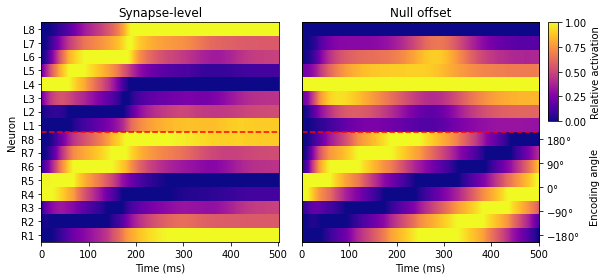

In [23]:
def normalize_state(states):
    # Normalizes the EPG states by hemisphere
    states = copy(states[:,slcs['epg']])
    nepg = states.shape[1]//2
    rmax = np.max(states[:,:nepg],axis=1,keepdims=True) 
    rmin = np.min(states[:,:nepg],axis=1,keepdims=True)
    lmax = np.max(states[:,nepg:],axis=1,keepdims=True)
    lmin = np.min(states[:,nepg:],axis=1,keepdims=True)
    states[:,:nepg] = (states[:,:nepg]-rmin)/(rmax-rmin)
    states[:,nepg:] = (states[:,nepg:]-lmin)/(lmax-lmin)
    return states
# Seperate figure for each test case
for i,g in states_df.groupby('test_no'):

    fig, axs = plt.subplots(1,2,figsize=(8,4))
    # Plot synapse level
    # Normalize, transpose for plotting
    states = normalize_state(states_matrices['Synapse-level'].iloc[i]).T
    ax = axs[0]
    im = ax.pcolormesh(states,cmap=cmap1)
    ax.title.set_text('Synapse-level')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron')
    # Label R/L
    ax.set_yticks(np.arange(16)+0.5)
    ax.set_yticklabels([''.join((x[0],str(x[1]))) for x in itertools.product('RL',range(1,9))])
    ax.axhline(8,color='r',ls='--')

    # Plot null offset
    states = normalize_state(states_matrices['Null offset'].iloc[i]).T
    ax = axs[1]
    im = ax.pcolormesh(states,cmap=cmap1)
    ax.title.set_text('Null offset')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron')
    ax.set_yticks(np.arange(16)+0.5)
    ax.set_yticklabels([''.join((x[0],str(x[1]))) for x in itertools.product('RL',range(1,9))])
    ax.axhline(8,color='r',ls='--')

    # Hide labels for clarity
    ax.set_ylabel('')
    ax.set_yticks([])
    # Make side labels
    tax = ax.twinx()
    # Hacky way to plot the labels correctly
    tax.set_yticks((np.linspace(0.5,7.5,5))/16)
    tax.set_yticklabels(['$-180\degree$','$-90\degree$','$0\degree$','$90\degree$','$180\degree$'])
    tax.set_ylabel('Encoding angle',y=0.25,labelpad=10.0)
    # Make colorbar
    cbar = plt.colorbar(im,shrink=0.45, location='right', use_gridspec=True, aspect=10, anchor=(0,1), label='Relative activation')
    ax = axs[0]
    ax2 = axs[1]
    ax3 = tax
    # Hacky resizing function to move the colorbar to a proper location
    def resize(event):
        axpos = ax.get_position()
        axpos2 = ax2.get_position()
        newpos = [axpos2.x0, axpos.y0,  axpos.width, axpos2.height] 
        ax2.set_position(newpos)
        ax3.set_position(newpos)
        cax = cbar.ax
        caxpos = cax.get_position()
        caxx = (axpos2.x0+axpos.width) + 0.015
        newpos = [caxx, caxpos.y0,  caxpos.width, caxpos.height] 
        cax.set_position(newpos)
    
    cid = fig.canvas.mpl_connect('draw_event', resize)
    cid2 = fig.canvas.mpl_connect('resize_event', resize)
    plt.tight_layout()
    fig.canvas.draw()
    resize(None)




rstate range:  (0.36310996192183126, 0.397217528065029)
lstate range:  (0.3640761447667382, 0.39818745630470215)
rstate range:  (0.7140695844233824, 0.7503156114052121)
lstate range:  (0.6001670700397774, 0.629740203308137)


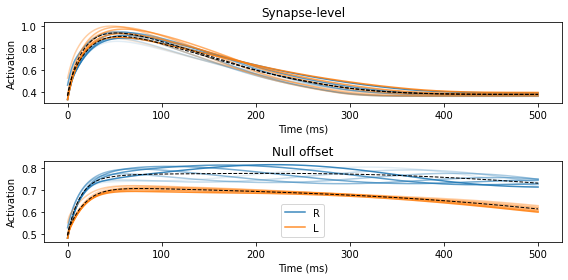

In [24]:

fig, axs = plt.subplots(2,1, figsize=(8,4))
network_types = ['Synapse-level','Null offset']
for i, ax in enumerate(axs):
    
    net_type = network_types[i]
    
    # Grab just the EPG states
    epg_states = states_matrices[net_type].iloc[0][:,slcs['epg']]
    ls = ax.plot(epg_states)
    # L/R hemispheres
    rstates = epg_states[:,:8]
    lstates = epg_states[:,8:]
    # Grab the mean
    rmean = np.mean(rstates,axis=1)
    lmean = np.mean(lstates,axis=1)
    print('rstate range: ', (np.min(rstates[-1,:]),np.max(rstates[-1,:])))
    print('lstate range: ', (np.min(lstates[-1,:]),np.max(lstates[-1,:])))
    ax.plot(lmean, color='k', ls='--',lw=1)
    ax.plot(rmean, color='k', ls='--',lw=1)
    for j,l in enumerate(ls):
        # Just want to label the last, full alpha one
        if j == 7:
            l.set_label('R')
        if j < 8:
            # Increase alpha for prettiness
            l.set_alpha(j/8)
            l.set_color(color3)
            
        if j >= 8:
            l.set_alpha((j-8)/8)
            l.set_color(color4)
        # Just want to label the last, full alpha one
        if j == 15:
            l.set_label('L')
    ax.title.set_text(net_type)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Activation')
    
plt.legend()
plt.tight_layout()
plt.savefig('states_lineplot.pdf')

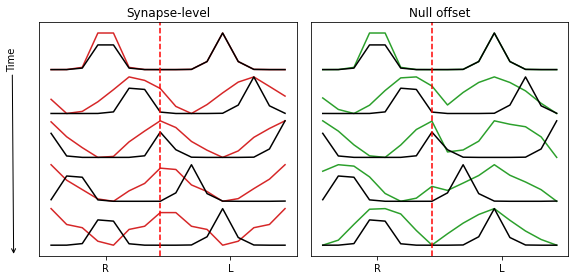

In [25]:
# Create bump function -- needs to be changed if the training data is different
gt_bump_fn = create_epg_bump_fn(N_EPG, fwhm=np.pi/3,scaling_factor=1.,hemisphere_offset=True)

def plot_bump(ax,net_type,time_slc=-1,shift=0, **kwargs):
    # The shift moves the bump along the y axis, which allows us to plot multiple
    bump = gt_bump_fn(angle_df[angle_df.network_type==net_type].iloc[time_slc].ground_truth) + shift
    
    curr_state = normalize_state(states_matrices[net_type].iloc[0])[time_slc,slcs['epg']] + shift
    curr_statel = ax.plot(curr_state,color=color1, **kwargs)
    # Plot the ground truth bump
    ax.plot(bump, color='k', **kwargs)
    ax.title.set_text(net_type)
    ax.set_yticks([])
    return curr_state,bump, curr_statel

fig, axs = plt.subplots(1,2,squeeze=False,figsize=(8,4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    try:
        net_type = network_types[i]
        for tt,t in enumerate(np.linspace(0, 499, 5,)):
            t = int(t)
            
            curr_state, bump, curr_statel = plot_bump(ax,net_type,t,shift=-(tt+0.2*tt))
            if i != 0:
                for l in curr_statel:
                    l.set_color(color2)
        # Line down the middle to distinguish the two hemispheres
        ax.axvline(7, color='r',ls='--')
        ax.set_xticks([3.5, 11.5])
        ax.set_xticklabels(['R','L'])
        
    except IndexError:
        ax.axis('off')
        raise
# Annotate the time arrow
axs[0].annotate('Time', xy=(-0.1, 0), xycoords='axes fraction', xytext=(-0.125, 0.8), arrowprops=dict(arrowstyle="->", color='k'),rotation='vertical')
plt.tight_layout()
